# Examples for the QuanFin Library
## Author: Gustavo Amarante

I built this library during my studies for the CQF. I know I am not the first one to program these functionalities, but doing so helped me truly understand them.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

---
# Option Pricing

## Binomial Tree

In [1]:
from quantfin.options import BinomalTree

The `BinomialTree` class can price american/european calls/puts.

As a first example here is the price of an american put option on a stock.

In [6]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=4,
                 call=False,
                 option_type='american')

bt.price

2.7452952388441347

If we change the option type to european, we are not allowed to exercise the option before maturity, restricting the possibilities of making a profit. So an european put should be cheaper than an american put.

In [9]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=4,
                 call=False,
                 option_type='european')

bt.price

2.6389737155978104

The model assumes that the underlying stock price evolves through a binomial tree. You can use the `chart_stock` method to see the trajectories of this tree. The example below uses 3 steps.

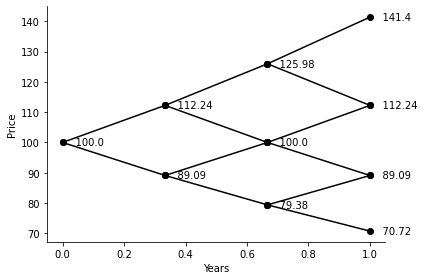

In [10]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=3,
                 call=False,
                 option_type='european')

fig = bt.chart_stock(labels=True)
plt.show()

We can also build a tree with more steps and hide the labels.

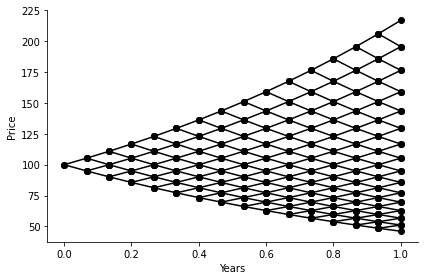

In [13]:
bt = BinomalTree(stock=100,
                 strike=90,
                 years2mat=1,
                 vol=0.20,
                 risk_free=0.05,
                 div_yield=0,
                 n=15,
                 call=False,
                 option_type='european')

fig = bt.chart_stock(labels=False)
plt.show()

As we have learned, as the number of steps/subdivision of the binomial tree increases, the price of the Binomial model converges to the Black-Scholes-Merton model. We can run the `BinomialTree` for several values of `n` and see how does the price converges.

We can see on the chart below that the convergence is not smooth.

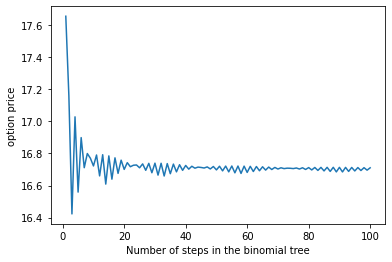

In [14]:
def option_price(n=1):
    return BinomalTree(stock=100, strike=90, years2mat=1, vol=0.20, risk_free=0.05, n=n).price


n_grid = np.arange(1, 101, 1, dtype=int)

plt.figure()
plt.plot(n_grid, list(map(option_price, n_grid)))
plt.xlabel('Number of steps in the binomial tree')
plt.ylabel('option price')
plt.show()

---
# Simulation

## Diffusion Processes